## Домашнее задание
Датасет

Цель:
Собрать и подготовить свой собственный датасет, можно в соответствии с темой будущего проекта.
Аугментировать данные техниками из занятия.
Примеры:

сделать 100 фото предметов на одном/нескольких фонах, при одном/разном освещении и т.д.
снять видео с домашним животным и разметить (кот лежит, кот бежит, кот ест).

Описание/Пошаговая инструкция выполнения домашнего задания:
Взять предобученную модель.
Применить несколько стратегий аугментации данных (albumentations, torchvision или еще что-то на ваш вкус).
Собрать результаты успешности стратегий в сводную табличку.
Большим плюсом будет применение Pytorch Lightning для упорядочивания вашего проекта, но это не обязательное требование.

Критерии оценки:
"Принято", если:

Есть сводная табличка в конце со сравнением стратегий.
У каждой стратегии есть краткое понятное описание, что именно сделано.
Есть визуализация собранного датасета.
"Возвращено на доработку" - задание не выполнено полностью.

### EDA

Разведочный анализ данных выполнен в ноутбуке "/notebooks/EDA.ipynb"|

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

import os
import sys
sys.path.append(os.path.abspath('..'))

import cv2
import torch
import pandas as pd
from PIL import Image
from pprint import pprint
import albumentations as albu
from albumentations.pytorch import ToTensorV2

import warnings
warnings.simplefilter('ignore')

/Users/aleksandrkrylov/Documents/JULIII/ML_Courses/CV_OTUS/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
DATA_PATH = '../data_sports/'
df_10 = pd.read_csv(DATA_PATH + 'train_set_10.csv')

### Выбранные стратении аугментации

В работе были использованы  4 стратегии аугментации с применением библиотеки albumentations
1) без аугментаций
2) аугментаци изменяющие только цветовые характеристики и добавляющие шум
3) аугментаци изменяющие изображения только геометрически
4) комбинация 2 и 3 стратерий


In [4]:
color_noise_transform = albu.Compose([
        albu.CLAHE(clip_limit=4.0),
        albu.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.6),
        albu.GaussNoise(),
        albu.OneOf([
            albu.MotionBlur(p=.2),
            albu.MedianBlur(blur_limit=3, p=0.1),
            albu.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
    ])

geometry_transform = albu.Compose([
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.3, rotate_limit=30, p=0.5),
        albu.RandomResizedCrop(height=224, width=224, scale=(0.5, 1.0), ratio=(0.8, 1.2), p=0.5),
    ])

combined_transform = albu.Compose([
        color_noise_transform,
        geometry_transform,
    ])

In [5]:
#Сохраняем конфиги для стратегий аугментации
albu.save(color_noise_transform, '../configs/transform_color.yaml', data_format='yaml')
albu.save(geometry_transform, '../configs/transform_geometry.yaml', data_format='yaml')
albu.save(combined_transform, '../configs/transform_combined.yaml', data_format='yaml')

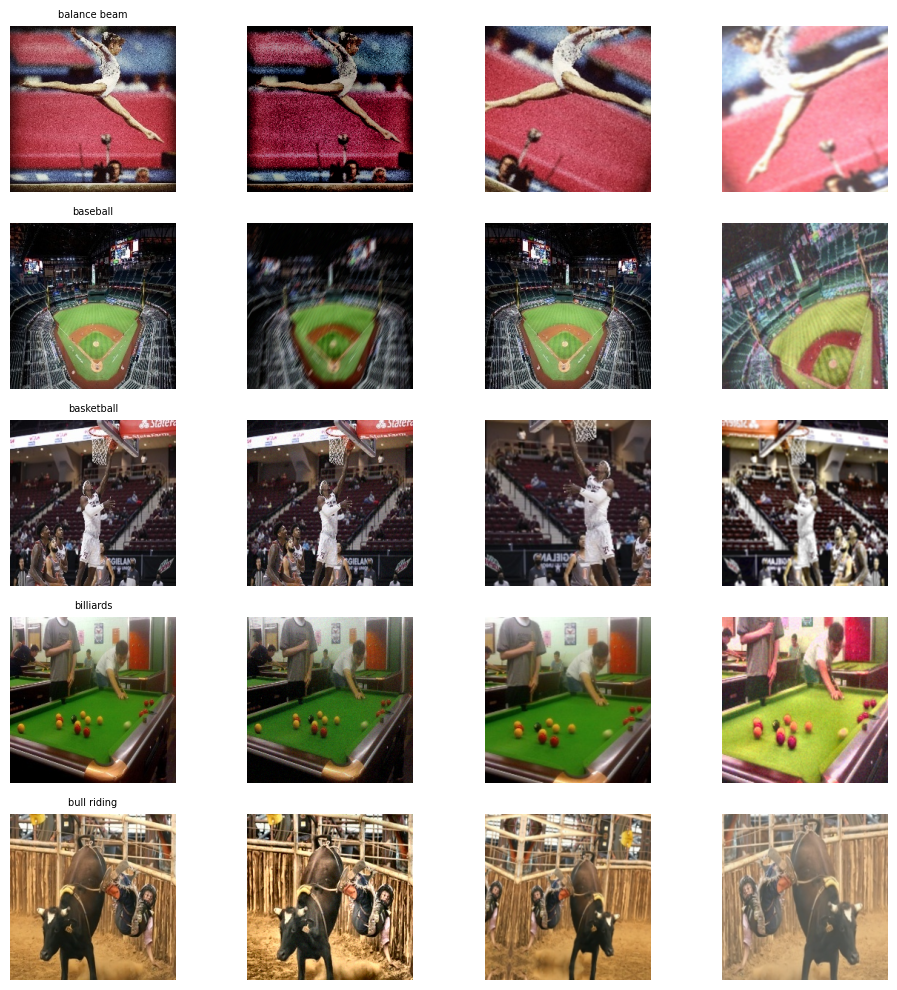

In [6]:
# Visualize images with augs 

import random
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for ind, lbl in enumerate(df_10['labels'].unique()[:5]):
    # Original image
    filename = random.choice(df_10[df_10['labels'].isin([lbl])]['filepaths'].values)
    img_path = os.path.join(DATA_PATH, filename)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented_image_color = color_noise_transform(image=image)['image']
    augmented_image_geometry = geometry_transform(image=image)['image']
    augmented_image_combined = combined_transform(image=image)['image']
    
    # Plot images
    ax = plt.subplot(5, 4, ind*4 + 1)
    ax.set_title(lbl, fontsize=7)
    ax.imshow(image)
    ax.axis('off')
    
    ax = plt.subplot(5, 4, ind*4 + 2)
    ax.imshow(augmented_image_color)
    ax.axis('off')
    
    ax = plt.subplot(5, 4, ind*4 + 3)
    ax.imshow(augmented_image_geometry)
    ax.axis('off')
    
    ax = plt.subplot(5, 4, ind*4 + 4)
    ax.imshow(augmented_image_combined)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

### Задача классификации решалась с помощью пердобученной моедли resnet18 с использованием фреймфорка Pytorch Lightning

Код для обучения моедли в папке src

Ниже запускаются на счет 4 варианта модели с указанными выше стратегиями аугментации

In [7]:
# Запуск обучения модели на Pytoch Lightning  БЕЗ АУГМЕНТАЦИИ (стратегия 1)
torch.cuda.empty_cache()
%cd ..
!python src/train.py configs/res18_no_aug.yaml
%cd -

c:\Users\julia\CV\CV_5_Augmentations
ClearML Task: created new task id=b47ad10287284205abcc8cc4968470f8
2024-03-08 00:19:13,627 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/b098de020bb8433c96c51c11dd668389/experiments/b47ad10287284205abcc8cc4968470f8/output/log

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]
                                                                           

Training: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 79/79 [00:16<00:00,  4.76it/s, v_num=0]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/17 [00:00<?, ?it/s]

Validation DataLoader 0:   6%|▌         | 1/17 [00:00<00:02,  6.83it/s]

Validation DataLoader 0:  12%|█▏        | 2/17 [00:00<00:01,  9.70it/s]

Validation DataLoader 0:  18%|█▊        | 3/17 [00:00<00:01, 13.63it/s]

Vali

Global seed set to 100
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:Original dataset: 900
INFO:root:Final dataset: 900
INFO:root:Stratifying dataset is completed.
INFO:root:Train dataset: 630
INFO:root:Valid dataset: 135
INFO:root:Test dataset: 135
INFO:root:Datasets successfully saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | _model         | ResNet           | 11.2 M
1 | _valid_metrics | MetricCollection | 0     
2 | _test_metrics  | MetricCollection | 0     
----------------------------------------------------
1

In [8]:
# Запуск обучения модели на Pytoch Lightning с аугментациями изменяющими только цветовые характеристики (стратегия 2)
torch.cuda.empty_cache()
%cd ..
!python src/train.py configs/res18_color_aug.yaml --aug_yaml configs/transform_color.yaml

%cd -

c:\Users\julia\CV\CV_5_Augmentations


ClearML Task: created new task id=a4c4077669d04644a7040048c3d08b64
2024-03-08 00:33:07,908 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/b098de020bb8433c96c51c11dd668389/experiments/a4c4077669d04644a7040048c3d08b64/output/log

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]
                                                                           

Training: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 79/79 [00:16<00:00,  4.68it/s, v_num=1]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/17 [00:00<?, ?it/s]

Validation DataLoader 0:   6%|▌         | 1/17 [00:00<00:01, 14.13it/s]

Validation DataLoader 0:  12%|█▏        | 2/17 [00:00<00:01, 13.12it/s]

Validation DataLoader 0:  18%|█▊        | 3/17 [00:00<00:01, 13.26it/s]

Validation DataLoader 0:  24%|██▎       |

Global seed set to 100
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:Original dataset: 900
INFO:root:Final dataset: 900
INFO:root:Stratifying dataset is completed.
INFO:root:Train dataset: 630
INFO:root:Valid dataset: 135
INFO:root:Test dataset: 135
INFO:root:Datasets successfully saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | _model         | ResNet           | 11.2 M
1 | _valid_metrics | MetricCollection | 0     
2 | _test_metrics  | MetricCollection | 0     
----------------------------------------------------
1

In [9]:
# Запуск обучения модели на Pytoch Lightning с аугментациями изменяющие изображения только геометрически (стратегия 3)
torch.cuda.empty_cache()
%cd ..

!python src/train.py configs/res18_geom_aug.yaml --aug_yaml configs/transform_geometry.yaml

%cd -

c:\Users\julia\CV\CV_5_Augmentations


ClearML Task: created new task id=d3dfb2852e744af0ac2512bce598aa46
2024-03-08 00:47:24,632 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/b098de020bb8433c96c51c11dd668389/experiments/d3dfb2852e744af0ac2512bce598aa46/output/log

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]
                                                                           

Training: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 79/79 [00:16<00:00,  4.76it/s, v_num=2]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/17 [00:00<?, ?it/s]

Validation DataLoader 0:   6%|▌         | 1/17 [00:00<00:02,  7.21it/s]

Validation DataLoader 0:  12%|█▏        | 2/17 [00:00<00:02,  7.38it/s]

Validation DataLoader 0:  18%|█▊        | 3/17 [00:00<00:01,  9.23it/s]

Validation DataLoader 0:  24%|██▎       |

Global seed set to 100
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:Original dataset: 900
INFO:root:Final dataset: 900
INFO:root:Stratifying dataset is completed.
INFO:root:Train dataset: 630
INFO:root:Valid dataset: 135
INFO:root:Test dataset: 135
INFO:root:Datasets successfully saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | _model         | ResNet           | 11.2 M
1 | _valid_metrics | MetricCollection | 0     
2 | _test_metrics  | MetricCollection | 0     
----------------------------------------------------
1

In [10]:
# Запуск обучения модели на Pytoch Lightning с комбинацией всех аугментаций (стратегия 4)
torch.cuda.empty_cache()
%cd ..

!python src/train.py configs/res18_COMB_aug.yaml --aug_yaml configs/transform_combined.yaml

%cd -

c:\Users\julia\CV\CV_5_Augmentations


ClearML Task: created new task id=d4c2bf8311cb4f23b614c231ce59664e
2024-03-08 01:01:23,973 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/b098de020bb8433c96c51c11dd668389/experiments/d4c2bf8311cb4f23b614c231ce59664e/output/log

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]
                                                                           

Training: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 79/79 [00:17<00:00,  4.64it/s, v_num=3]

Validation: 0it [00:00, ?it/s]

Validation:   0%|          | 0/17 [00:00<?, ?it/s]

Validation DataLoader 0:   0%|          | 0/17 [00:00<?, ?it/s]

Validation DataLoader 0:   6%|▌         | 1/17 [00:00<00:01, 14.54it/s]

Validation DataLoader 0:  12%|█▏        | 2/17 [00:00<00:01, 14.43it/s]

Validation DataLoader 0:  18%|█▊        | 3/17 [00:00<00:00, 14.30it/s]

Validation DataLoader 0:  24%|██▎       |

Global seed set to 100
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:Original dataset: 900
INFO:root:Final dataset: 900
INFO:root:Stratifying dataset is completed.
INFO:root:Train dataset: 630
INFO:root:Valid dataset: 135
INFO:root:Test dataset: 135
INFO:root:Datasets successfully saved!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | _model         | ResNet           | 11.2 M
1 | _valid_metrics | MetricCollection | 0     
2 | _test_metrics  | MetricCollection | 0     
----------------------------------------------------
1

In [ ]:
#export tensorboard logs to csv
from src.tb2csv import tb_extract

for filepath in os.listdir('../lightning_logs/'):
    if 'version' in filepath:
        for filepath1 in os.listdir(os.path.join('../lightning_logs/', filepath)):
            print(filepath1)
            if 'events.out' in filepath1:
                tb_extract(logdir_or_logfile=f'../lightning_logs/{filepath}/{filepath1}', write_pkl=False, write_csv=True, out_dir='../lightning_logs/csv/', csv_name = f"{filepath1}.csv")

In [10]:
#Load training results to pandas dataframe and visualize
csv_dir = '../lightning_logs/csv'
data = []

for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):
        filepath = os.path.join(csv_dir, filename)
        df = pd.read_csv(filepath)
        for index, row in df.iterrows():
            data.append({
                'filename': filename.split('.')[0],
                'metric': row['metric'],
                'value': row['value'],
                'step': row['step']
            })
result_df = pd.DataFrame(data, columns=['filename', 'metric', 'value', 'step'])

result_df.head(3)


,filename,metric,value,step
0,COMB_aug_train_val,hp_metric,-1.000,0.0
1,COMB_aug_train_val,lr-AdamW,0.001,0.0
2,COMB_aug_train_val,lr-AdamW,0.001,79.0


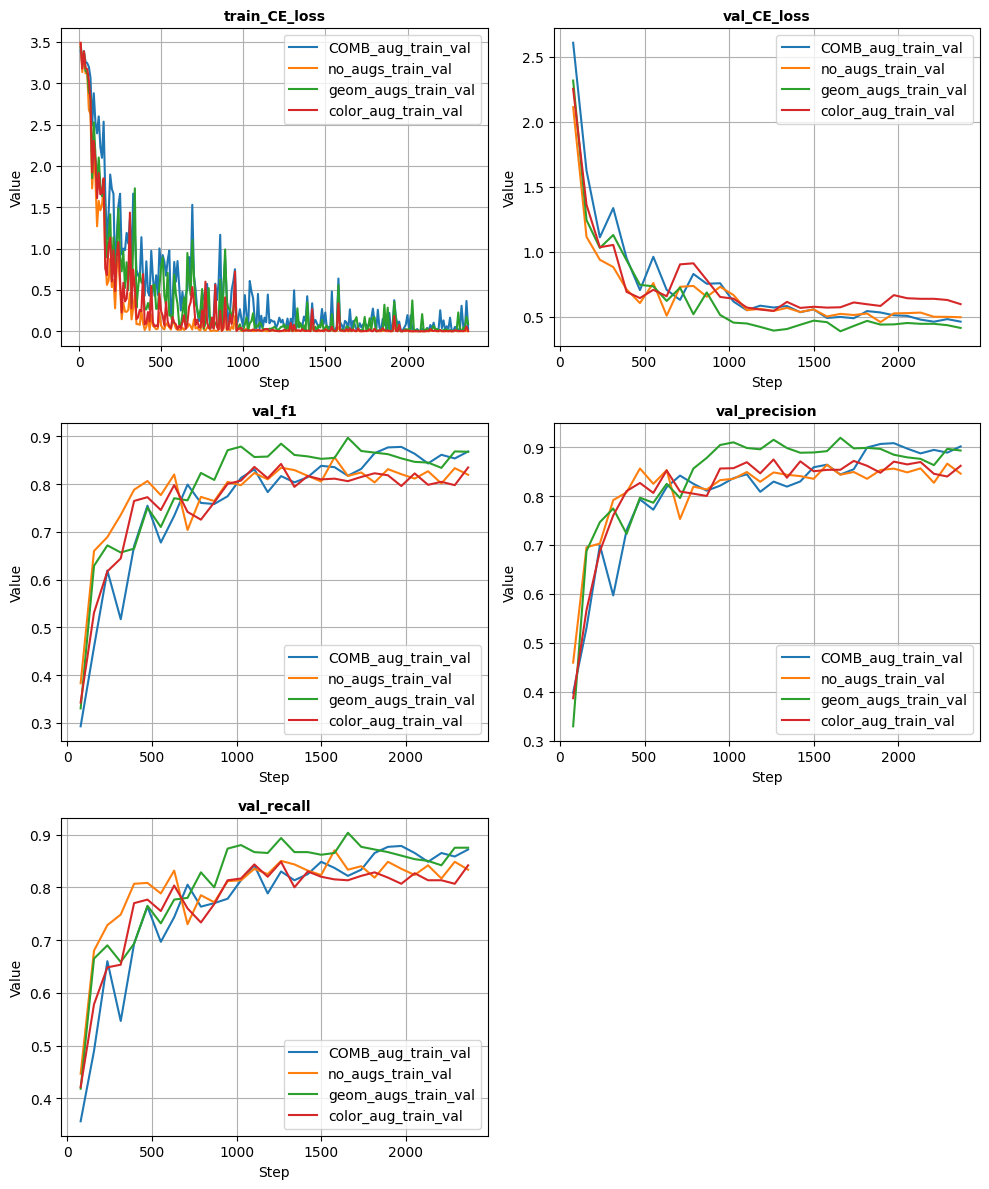

In [35]:
# Visualize training results for all strategies
import matplotlib.pyplot as plt

metric_list = ['train_CE_loss', 'val_CE_loss', 'val_f1', 'val_precision', 'val_recall']

filenames = [filename for filename in result_df['filename'].unique() if not filename.endswith('_test')]

plt.figure(figsize=(10, 12))
for ind, metric in enumerate(metric_list):
    ax = plt.subplot(3, 2, ind + 1) 
    ax.set_title(metric, fontsize=10, fontweight='bold')
    ax.set_xlabel("Step")
    ax.set_ylabel("Value")
    ax.grid(True)
    
    for filename in filenames:
        df = result_df[(result_df['filename'] == filename) & (result_df['metric'] == metric)]
        ax.plot(df['step'], df['value'], label=filename)

    ax.legend() 

plt.tight_layout()
plt.show()


In [34]:
# Create summary table for test metrics
metric_list_test = ['test_f1', 'test_precision', 'test_recall']
filenames_test = [filename for filename in result_df['filename'].unique() if filename.endswith('_test')]

result_df_test = result_df[result_df['filename'].isin(filenames_test)]
summary_df = result_df_test.pivot_table(index='filename', columns='metric', values='value').reset_index()
summary_df = summary_df[['filename'] + metric_list_test]

summary_df.sort_values(by='test_f1', ascending=False)


metric,filename,test_f1,test_precision,test_recall
2,geom_augs_test,0.993266,0.994444,0.993333
1,color_aug_test,0.977008,0.982222,0.976667
3,no_augs_test,0.964045,0.972698,0.963333
0,COMB_aug_test,0.962867,0.970000,0.963333


По результатам сравнения стратегий наилучий результат был достигнут применением геометрических аугментаций, которые позволил моедил выучить больше полезных фичей из ограниченного тренироваочного датасета

Цветовые аугментации немного снизили результат